In [1]:
import scanpy as sc
import scvi

Global seed set to 0


In [2]:
adata = scvi.data.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/anndata_atac_peak_matrix.h5ad")

We filter peaks that are not detected in at least 5% of the cells. Instead of 180,499 cells we are then left with 65,435 cells. This is interesting, because Ricard apparently has used peaks which are less frequent than in at least 5% of cells. Maybe the reason for this is that we have celltypes with few cells and we don't want to remove peaks which are specific to these more rare celltypes.

In [3]:
print(adata.shape)
# compute a threshold of 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
print(min_cells)
# filter the regions using scanpy
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(45991, 180499)
2299
(45991, 65435)


To make the training faster we can convert the sparse matrix to CSR format.

In [4]:
from scipy.sparse import csr_matrix

In [5]:
copy_mat = adata.X.copy()

In [6]:
csr_matrix = csr_matrix(copy_mat)

In [7]:
adata.layers["csr"] = csr_matrix

In [8]:
scvi.model.PEAKVI.setup_anndata(adata,  
                                layer = "csr",
                                categorical_covariate_keys=["Sample"])


In [9]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    
    dropout_rate=0.2,
    n_layers_encoder=2,
    n_layers_decoder=2,
    n_latent=20,
    latent_distribution="normal"
)

pvi = scvi.model.PEAKVI(
    adata,
    **arches_params
)

In [10]:
#pvi.train()

In [11]:
#pvi.save("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/peakVI_trained_model", overwrite=True)

In [16]:
# load trained model
pvi = scvi.model.PEAKVI.load("atac_gpu_trained_20_dim/", adata=adata, use_gpu=False)

In [17]:
# load anndata with latent space
adata = scvi.data.read_h5ad("atac_gpu_trained_20_dim/anndata_object_peakvi")

## Visualize and analyze the latent space

In [18]:
latent = pvi.get_latent_representation()
adata.obsm["X_PeakVI"] = latent

print(latent.shape)

(45991, 20)


In [19]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_PeakVI")
# compute the umap
sc.tl.umap(adata, min_dist=0.2)

In [28]:
colPalette_celltypes = ['#532C8A',
 '#c19f70',
 '#f9decf',
 '#c9a997',
 '#B51D8D',
 '#3F84AA',
 '#9e6762',
 '#354E23',
 '#F397C0',
 '#ff891c',
 '#635547',
 '#C72228',
 '#f79083',
 '#EF4E22',
 '#989898',
 '#7F6874',
 '#8870ad',
 '#647a4f',
 '#EF5A9D',
 '#FBBE92',
 '#139992',
 '#cc7818',
 '#DFCDE4',
 '#8EC792',
 '#C594BF',
 '#C3C388',
 '#0F4A9C',
 '#FACB12',
 '#8DB5CE',
 '#1A1A1A',
 '#C9EBFB',
 '#DABE99',
 '#65A83E',
 '#005579',
 '#CDE088',
 '#f7f79e',
 '#F6BFCB']

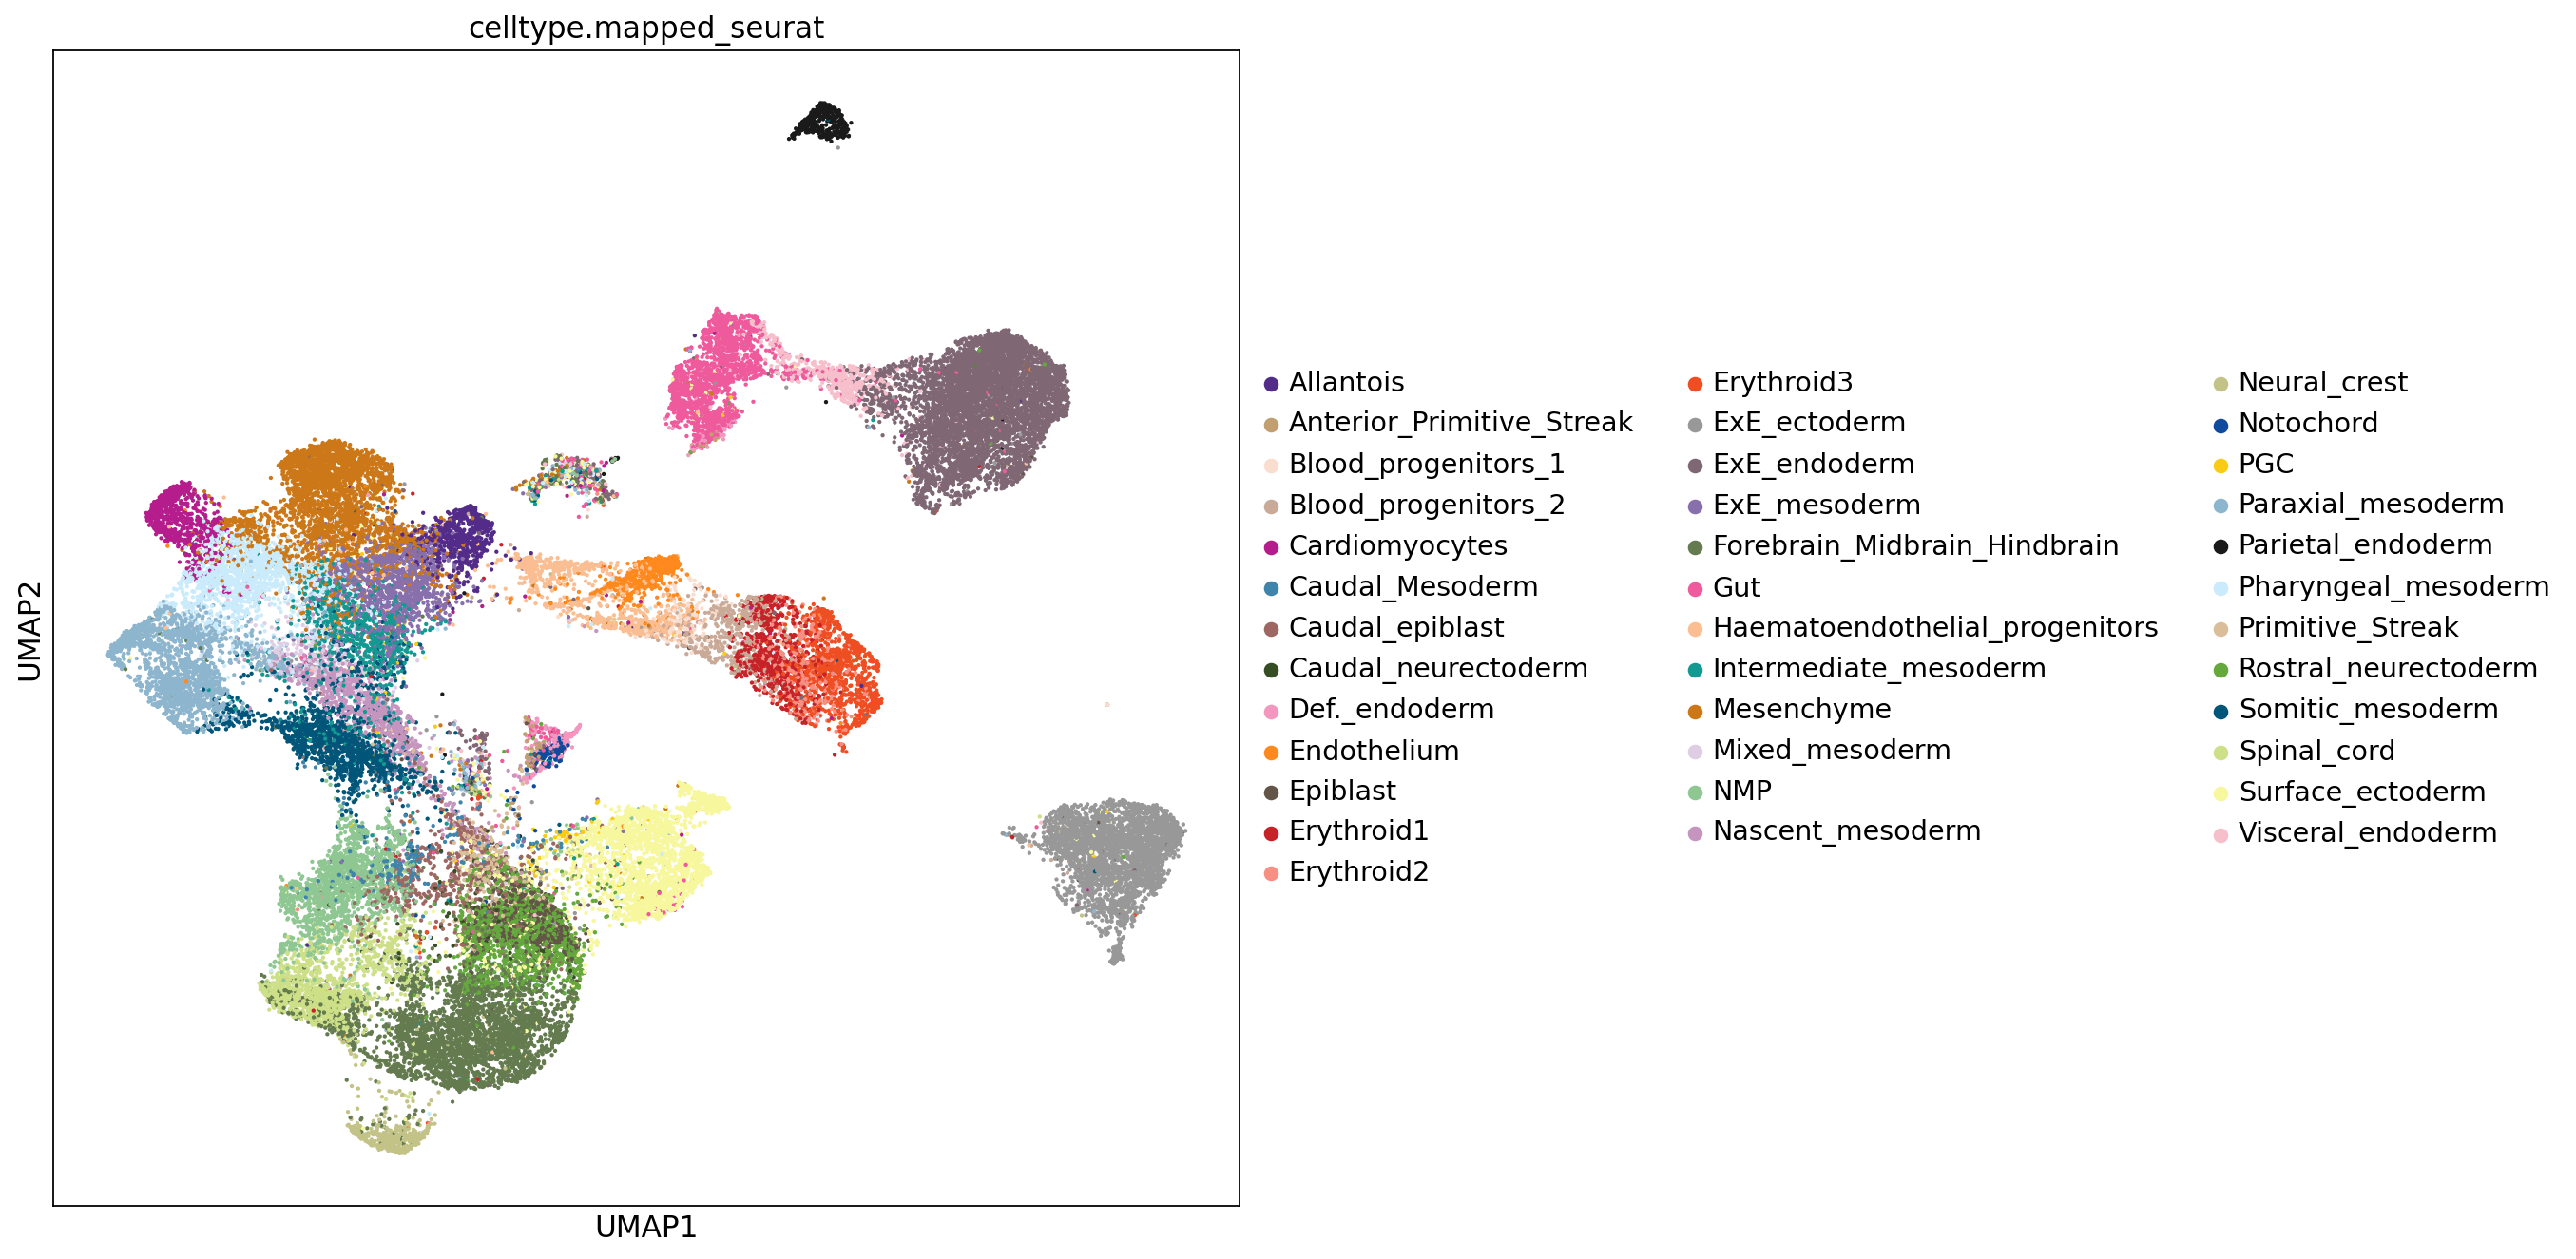

In [30]:
sc.set_figure_params(figsize=(10,10))

sc.pl.umap(
    adata,
    color='celltype.mapped_seurat',
    ncols=2,
    size=15,
    palette = colPalette_celltypes)

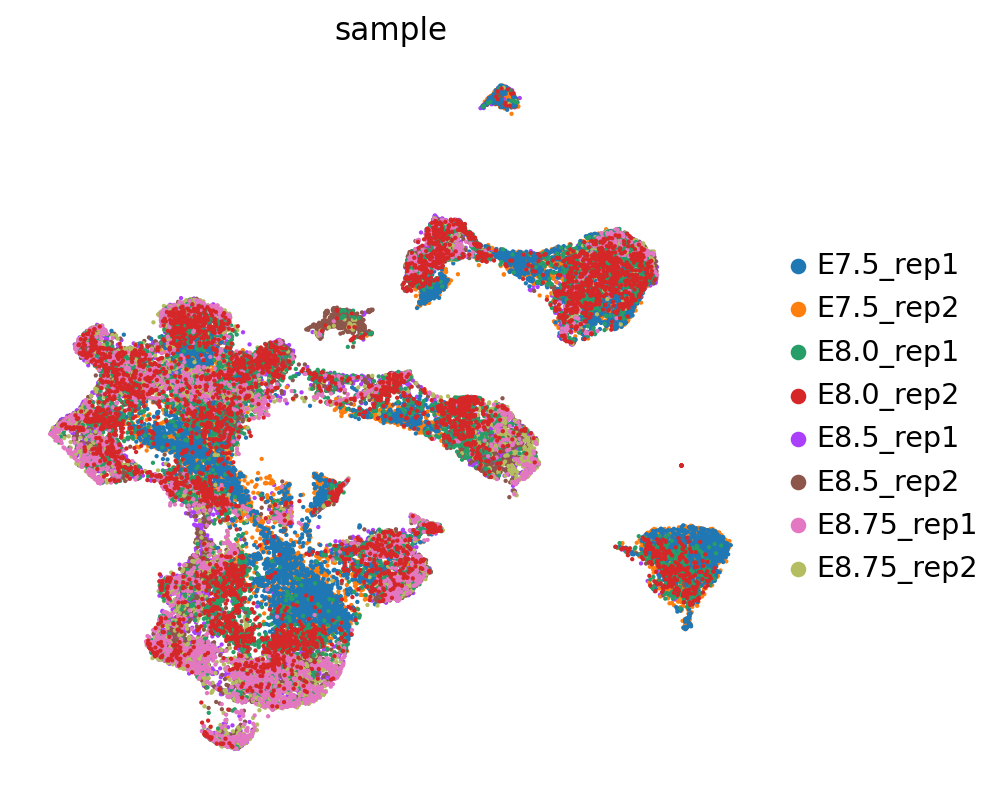

In [25]:
sc.set_figure_params(figsize=(6,6))
sc.pl.umap(
    adata,
    color=["sample"],
    ncols=2,
    frameon=False,
    size=15
)